In [2]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(), '../'))

import pickle
from tqdm import tqdm
from glob import glob
from collections import OrderedDict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cv2

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score

import torch
from transformers import AutoTokenizer, AutoModel, AutoConfig

from captum import attr

#from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization

from src import data, models, visualization

%matplotlib inline

In [2]:
torch.manual_seed(42)
np.random.seed(42)

In [3]:
train_df = data.load_data.load_custom_text_as_pd('../data/raw/COVID19Tweet/train.tsv',sep='\t', header=True, \
                          text_column=['Text'],target_column=['Label'])

val_df = data.load_data.load_custom_text_as_pd('../data/raw/COVID19Tweet/valid.tsv',sep='\t', header=False, \
                          text_column=['Text'],target_column=['Label'])
val_df = pd.DataFrame(val_df,copy=False)
val_df.columns = ['Id','words','labels']

In [4]:
train_df.head(5)

,Id,words,labels
0,1241490299215634434,Official death toll from #covid19 in the Unite...,INFORMATIVE
1,1245916400981381130,"Dearest Mr. President @USER 1,169 coronavirus ...",INFORMATIVE
2,1241132432402849793,Latest Updates March 20 ⚠️5274 new cases and 3...,INFORMATIVE
3,1236107253666607104,真把公主不当干部 BREAKING: 21 people on Grand Princess...,INFORMATIVE
4,1239673817552879619,OKLAHOMA CITY — The State Department of Educat...,UNINFORMATIVE


In [5]:
val_df.head(5)

,Id,words,labels
0,1241728922192142336,For those saying Pakistan isn’t Italy; After 3...,UNINFORMATIVE
1,1235713405992030209,Second case DR 🇩🇴 The Canadian woman has not b...,INFORMATIVE
2,1245941302367305728,Kill Chain: the cyber war on America's electio...,UNINFORMATIVE
3,1245913002840391681,Town hosts FIRST #Virtual #TownCouncil meeting...,UNINFORMATIVE
4,1240543259299987457,Report suggested that the actual number of und...,UNINFORMATIVE


In [6]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

I0904 20:22:32.564698 4515159488 configuration_utils.py:283] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /Users/victor/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.117c81977c5979de8c088352e74ec6e70f5c66096c28b61d3c50101609b39690
I0904 20:22:32.566252 4515159488 configuration_utils.py:319] Model config RobertaConfig {
  "_num_labels": 2,
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": 0,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL

### Plot TF-IDF Conditioned on label

In [7]:
vectorizer = TfidfVectorizer(
                         lowercase=True, #this will convert all the tokens into lower case
                         stop_words='english', #remove english stopwords from vocabulary. if we need the stopwords this value should be None
                         analyzer='word', #tokens should be words. we can also use char for character tokens
                         max_features=10000, #maximum vocabulary size to restrict too many features
                         min_df = 2,
                         max_df = .5,
                        )

In [8]:
visualization.visualize.plot_top_words_conditional(train_df.words,train_df.labels,vectorizer=vectorizer)

## Analyze models

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Analyze submitted Model

In [10]:
model_save_dir = '../models/submitted_model/'
max_text_len = 100
config = pickle.load(open(os.path.join(model_save_dir,'config.pkl'),'rb'))
label2idx = pickle.load(open(os.path.join(model_save_dir,'label2idx.pkl'),'rb'))
config

{'text_max_len': 100,
 'epochs': 15,
 'learning_rate': 2e-05,
 'batch_size': 32,
 'dropout': 0.2,
 'model_description': 'roberta-base mean of all tokens from last 4 layers'}

In [11]:
label2idx

{'UNINFORMATIVE': 0, 'INFORMATIVE': 1}

In [12]:
idx2label = {i:w for (w,i) in label2idx.items()}

In [13]:
val_df.labels, _ = data.data_utils.convert_categorical_label_to_int(val_df.labels, \
                                                         save_path=os.path.join(model_save_dir,'label2idx.pkl'))
valX = data.data_utils.compute_transformer_input_arrays(val_df, 'words', tokenizer, max_text_len)
val_outputs = data.data_utils.compute_output_arrays(val_df, 'labels')
val_dataset = data.data_utils.TorchDataLoader(valX[0], valX[1], valX[2], val_outputs)
val_data_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=16)

100%|██████████| 1000/1000 [00:00<00:00, 1833.39it/s]


In [14]:
model1 = models.torch_models.TransformerAvgPool('roberta-base', device, dropout=config['dropout'])

I0904 20:22:45.561637 4515159488 configuration_utils.py:283] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /Users/victor/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.117c81977c5979de8c088352e74ec6e70f5c66096c28b61d3c50101609b39690
I0904 20:22:45.562703 4515159488 configuration_utils.py:319] Model config RobertaConfig {
  "_num_labels": 2,
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": 0,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL

In [15]:
model1.load_state_dict(torch.load(os.path.join(model_save_dir, 'model.bin'),map_location=device))

<All keys matched successfully>

In [18]:
all_outputs1 = []
all_emb = []

with torch.no_grad():
    for bi, d in tqdm(enumerate(val_data_loader), total=len(val_data_loader)):
        ids = d['ids'].to(device)
        mask = d['mask'].to(device)
        token_type_ids = d['token_type_ids'].to(device)
        
        emb = model1.base_model(ids, mask, token_type_ids)[-1]
        emb = torch.cat([emb[i] for i in model1.layers], -1)
        emb = torch.mean(emb, 1)
        emb = model1.drop(emb)
        
        all_outputs1.extend(torch.sigmoid(model1(ids, mask, token_type_ids)).cpu().detach().numpy().tolist())
        all_emb.extend(emb.cpu().detach().numpy().tolist())
    
all_outputs1 = np.array(all_outputs1)
val_df['submitted_model'] = all_outputs1[:,0]
all_emb = np.array(all_emb)

100%|██████████| 63/63 [02:39<00:00,  2.54s/it]


In [19]:
val_df.head(10)

,Id,words,labels,submitted_model
0,1241728922192142336,For those saying Pakistan isn’t Italy; After 3...,0,0.790861
1,1235713405992030209,Second case DR 🇩🇴 The Canadian woman has not b...,1,0.999980
2,1245941302367305728,Kill Chain: the cyber war on America's electio...,0,0.000113
3,1245913002840391681,Town hosts FIRST #Virtual #TownCouncil meeting...,0,0.000340
4,1240543259299987457,Report suggested that the actual number of und...,0,0.003582
5,1244613970142662662,Death happens all the time but is something we...,1,0.999552
6,1241885583322071042,cw | coronavirus i can’t see my dad for a week...,1,0.988083
7,1236098806309150720,The issue? The Coronavirus cases in MoCo. The ...,0,0.001117
8,1251111178329358337,This is nothing more than BS rhetoric in an at...,0,0.000196
9,1236202072539717632,UPDATE: the two people at our Hail Creek opera...,1,0.999975


In [21]:
val_df[np.round(val_df.submitted_model) != val_df.labels].shape

(89, 4)

In [22]:
X_embedded = TSNE(n_components=2).fit_transform(all_emb)

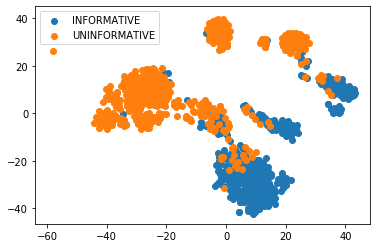

In [23]:
vis_data = pd.DataFrame()
vis_data['x'] = X_embedded[:,0]
vis_data['y'] = X_embedded[:,1]
vis_data['label'] = [idx2label[i] for i in val_df.labels.values]

plt.scatter(vis_data[vis_data.label == 'INFORMATIVE'].x, vis_data[vis_data.label == 'INFORMATIVE'].y, label='INFORMATIVE')
plt.scatter(vis_data[vis_data.label == 'UNINFORMATIVE'].x, vis_data[vis_data.label == 'UNINFORMATIVE'].y, label='UNINFORMATIVE')
plt.legend()

plt.savefig("../visualizations/embeddings.png", dpi=200)

### Analyze Multi-Sample Model

In [24]:
model_save_dir = '../models/multisample_model/'
max_text_len = 100
config = pickle.load(open(os.path.join(model_save_dir,'config.pkl'),'rb'))
config

{'text_max_len': 100,
 'epochs': 15,
 'learning_rate': 2e-05,
 'batch_size': 32,
 'dropout': 0.1,
 'mixout': 0,
 'l2': 0,
 'multi_sample_dropout_count': 7,
 'model_description': 'roberta-base with dropout 0.1, mixout prob 0, multi_sample_dropout_count 7 and l2 regularization 0'}

In [25]:
model2 = models.torch_models.TransformerMultiSample('roberta-base', device, dropout=config['dropout'],\
                                                   multi_sample_dropout_count=config['multi_sample_dropout_count'])


I0904 20:27:34.133363 4515159488 configuration_utils.py:283] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /Users/victor/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.117c81977c5979de8c088352e74ec6e70f5c66096c28b61d3c50101609b39690
I0904 20:27:34.134446 4515159488 configuration_utils.py:319] Model config RobertaConfig {
  "_num_labels": 2,
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": 0,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL

In [26]:
model2.load_state_dict(torch.load(os.path.join(model_save_dir, 'model.bin'),map_location=device))

<All keys matched successfully>

In [28]:
all_logits = []
all_outputs2 = []

with torch.no_grad():
    for bi, d in tqdm(enumerate(val_data_loader), total=len(val_data_loader)):
        ids = d['ids'].to(device)
        mask = d['mask'].to(device)
        token_type_ids = d['token_type_ids'].to(device)

        outputs = model2.base_model(ids, mask, token_type_ids)[0][:,0,:]
        outputs = torch.cat([model2.outs[i](model2.drops[i](outputs)) for i in range(model2.multi_sample_dropout_count)], -1)

        all_logits.extend(outputs.cpu().detach().numpy().tolist())

        all_outputs2.extend(torch.sigmoid(model2(ids, mask, token_type_ids)).cpu().detach().numpy().tolist())
    
all_logits = np.array(all_logits)
all_outputs2 = np.array(all_outputs2)
val_df['submitted_multidrop'] = all_outputs2[:,0]

100%|██████████| 63/63 [02:58<00:00,  2.84s/it]


In [29]:
val_df.head(10)

,Id,words,labels,submitted_model,submitted_multidrop
0,1241728922192142336,For those saying Pakistan isn’t Italy; After 3...,0,0.790861,0.452370
1,1235713405992030209,Second case DR 🇩🇴 The Canadian woman has not b...,1,0.999980,0.589302
2,1245941302367305728,Kill Chain: the cyber war on America's electio...,0,0.000113,0.438094
3,1245913002840391681,Town hosts FIRST #Virtual #TownCouncil meeting...,0,0.000340,0.420797
4,1240543259299987457,Report suggested that the actual number of und...,0,0.003582,0.434746
5,1244613970142662662,Death happens all the time but is something we...,1,0.999552,0.551503
6,1241885583322071042,cw | coronavirus i can’t see my dad for a week...,1,0.988083,0.606317
7,1236098806309150720,The issue? The Coronavirus cases in MoCo. The ...,0,0.001117,0.398666
8,1251111178329358337,This is nothing more than BS rhetoric in an at...,0,0.000196,0.424126
9,1236202072539717632,UPDATE: the two people at our Hail Creek opera...,1,0.999975,0.570432


In [30]:
corr = np.corrcoef(all_logits.T)

In [31]:
non_diag = np.where(~np.eye(corr.shape[0],dtype=bool))
mean_corr = np.mean([corr[non_diag[0][i],non_diag[1][i]] for i in range(len(non_diag[0]))])
var_corr = np.var([corr[non_diag[0][i],non_diag[1][i]] for i in range(len(non_diag[0]))])

mean_corr, var_corr

(-0.004359270161846984, 0.4057631492143634)

### Augmentation model

In [36]:
model_save_dir = '../models/augmented_model/'
max_text_len = 100
config = pickle.load(open(os.path.join(model_save_dir,'config.pkl'),'rb'))
config

{'text_max_len': 100,
 'epochs': 15,
 'learning_rate': 2e-05,
 'batch_size': 32,
 'dropout': 0.1,
 'mixout': 0,
 'l2': 0,
 'multi_sample_dropout_count': 0,
 'model_description': 'roberta-base with dropout 0.1, mixout prob 0, multi_sample_dropout_count 0, l2 regularization 0 and augmentation rate 0.1'}

In [37]:
model3 = models.torch_models.Transformer('roberta-base', dropout=config['dropout'])

I0904 20:32:59.257117 4515159488 configuration_utils.py:283] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /Users/victor/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.117c81977c5979de8c088352e74ec6e70f5c66096c28b61d3c50101609b39690
I0904 20:32:59.258181 4515159488 configuration_utils.py:319] Model config RobertaConfig {
  "_num_labels": 2,
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": 0,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL

In [38]:
model3.load_state_dict(torch.load(os.path.join(model_save_dir, 'model.bin'),map_location=device))

<All keys matched successfully>

In [39]:
all_outputs3 = []

with torch.no_grad():
    for bi, d in tqdm(enumerate(val_data_loader), total=len(val_data_loader)):
        ids = d['ids'].to(device)
        mask = d['mask'].to(device)
        token_type_ids = d['token_type_ids'].to(device)

        all_outputs3.extend(torch.sigmoid(model3(ids, mask, token_type_ids)).cpu().detach().numpy().tolist())
    
all_outputs3 = np.array(all_outputs3)
val_df['augmented_model'] = all_outputs3[:,0]

100%|██████████| 63/63 [01:27<00:00,  1.39s/it]


### Mixout Model

In [40]:
model_save_dir = '../models/mixout_model/'
max_text_len = 100
config = pickle.load(open(os.path.join(model_save_dir,'config.pkl'),'rb'))
config

{'text_max_len': 100,
 'epochs': 15,
 'learning_rate': 2e-05,
 'batch_size': 32,
 'dropout': 0,
 'mixout': 0.6,
 'l2': 0,
 'multi_sample_dropout_count': 0,
 'model_description': 'roberta-base with dropout 0, mixout prob 0.6, multi_sample_dropout_count 0, l2 regularization 0 and augmentation rate 0.3'}

In [41]:
checkpoints = glob(model_save_dir+'*.ckpt')
best_checkpoint = torch.load(checkpoints[0],map_location=device)
updated_checkpoint_state = OrderedDict([('.'.join(key.split('.')[1:]), v) for key, v in best_checkpoint['state_dict'].items()])

In [42]:
model4 = models.torch_models.TransformerWithMixout('roberta-base', mixout_prob=config['mixout'])

I0904 20:35:17.903331 4515159488 configuration_utils.py:283] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /Users/victor/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.117c81977c5979de8c088352e74ec6e70f5c66096c28b61d3c50101609b39690
I0904 20:35:17.905615 4515159488 configuration_utils.py:319] Model config RobertaConfig {
  "_num_labels": 2,
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": 0,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL

In [43]:
model4.load_state_dict(updated_checkpoint_state)

<All keys matched successfully>

In [44]:
del best_checkpoint

In [45]:
all_outputs4 = []

with torch.no_grad():
    for bi, d in tqdm(enumerate(val_data_loader), total=len(val_data_loader)):
        ids = d['ids'].to(device)
        mask = d['mask'].to(device)
        token_type_ids = d['token_type_ids'].to(device)

        all_outputs4.extend(torch.sigmoid(model4(ids, mask, token_type_ids)).cpu().detach().numpy().tolist())
    
all_outputs4 = np.array(all_outputs4)
val_df['mixout_model'] = all_outputs4[:,0]

100%|██████████| 63/63 [02:07<00:00,  2.02s/it]


In [46]:
val_df[np.round(val_df.submitted_model) != val_df.labels][(np.round(val_df.submitted_multidrop) == val_df.labels) | (np.round(val_df.augmented_model) == val_df.labels) | (np.round(val_df.mixout_model) == val_df.labels)].shape


/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(47, 7)

In [58]:
val_df[np.round(val_df.submitted_model) != val_df.labels][(np.round(val_df.submitted_multidrop) == val_df.labels) | (np.round(val_df.augmented_model) == val_df.labels) | (np.round(val_df.mixout_model) == val_df.labels)].labels.value_counts(normalize=True)

/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
I0904 20:47:30.804346 4515159488 utils.py:141] NumExpr defaulting to 4 threads.


0    0.680851
1    0.319149
Name: labels, dtype: float64

In [47]:
val_df[np.round(val_df.submitted_model) != val_df.labels][np.round(val_df.augmented_model) == val_df.labels][np.round(val_df.submitted_multidrop) == val_df.labels][np.round(val_df.mixout_model) == val_df.labels]


/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Id,words,labels,submitted_model,submitted_multidrop,augmented_model,mixout_model
51,1245854291606175744,@USER @USER Ebola percentages are ridiculously...,0,0.897661,0.446469,0.016889,0.066051
72,1240487168071684096,if anyone in Austin has a place to stay for ju...,0,0.665349,0.489609,0.001540,0.000716
122,1240320280964272128,I just stopped by the Cajundome where #coronav...,0,0.937953,0.460776,0.049254,0.003686
165,1247042321524248576,Breaking: Scott Morrison says ministerial resp...,0,0.993836,0.492895,0.000367,0.001408
268,1252198354135789569,@USER This is a photo of President Johnson in ...,0,0.701498,0.411485,0.376746,0.177634
278,1241293771225980928,#kanikakapoor #Nagpur #IndianRailways 3 above ...,1,0.303034,0.562479,0.900624,0.996662
304,1241462078923132928,Assuming current status - projected the daily ...,0,0.967763,0.482445,0.467519,0.036044
323,1244603769939283971,@USER Very surprised with the muted action! $P...,0,0.930685,0.457039,0.000571,0.002119
429,1243561849070784515,@USER @USER And one @USER from Australia is dr...,0,0.857894,0.419775,0.357657,0.001756
532,1245675163036852226,"@USER @USER @USER Well, they’re certainly havi...",0,0.999834,0.486570,0.349476,0.214645


In [65]:
val_df.words.iloc[278]

"#kanikakapoor #Nagpur #IndianRailways 3 above cases alone enough for #india govt to declare stage 3 and lockdown for 15 days. BJP isn't doing so immediately as pr exercise #JantaCurfew will be junked. Politics in dire times 🤢 #coronavirus #coronavirusindia"

In [76]:
val_df.words.iloc[879]

'Interesting. Could this have been covid19? If it was in China in october/november what are the chances that there were 0 cases here until the end of january?'

In [61]:
val_df.words.iloc[165]

'Breaking: Scott Morrison says ministerial responsibility for public service matters, including the Australian Public Service Commission, has been temporarily transferred from Greg Hunt to Ben Morton, the Assistant Minister to the Prime Minister and Cabinet, due to coronavirus'

In [66]:
val_df.words.iloc[532]

'@USER @USER @USER Well, they’re certainly having no issues begging in Italy or Spain. Our continued determination to cling to optimistic outlooks only is what led us to keep our borders open until COVID got a big foothold. Now we’re happy to assume it’ll blow over and we’re still at &lt; 200 cases'

### Captum Interpretation

In [52]:
def captum_text_interpreter(idx, model, tokenizer, idx2label):
    text = val_df.words.iloc[idx]
    
    d = {
            "ids": torch.tensor([valX[0][idx,:]], dtype=torch.long),
            "mask": torch.tensor([valX[1][idx,:]], dtype=torch.long),
            "token_type_ids": torch.tensor([valX[2][idx,:]], dtype=torch.long)
        }

    orig_tokens = tokenizer.tokenize(text,add_special_tokens=True)
    
    model.to(device)                              
    model.eval()

    preds_proba = torch.sigmoid(model(d["ids"].to(device),d["mask"].to(device),d["token_type_ids"].to(device))).detach().cpu().numpy()
    preds = np.round(preds_proba)
    preds_proba = preds_proba[0][0]
    predicted_class = idx2label[preds[0][0]]

    lig = attr.LayerIntegratedGradients(model, model.base_model.embeddings)
    
    reference_indices = [0] + [1]*(d["ids"].shape[1]-2) + [2]
    reference_indices = torch.tensor([reference_indices], dtype=torch.long)
    
    attributions_ig, delta = lig.attribute(inputs=d["ids"],baselines=reference_indices,additional_forward_args=(d["mask"],d["token_type_ids"]), \
                                           return_convergence_delta=True)
    
    attributions = attributions_ig.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.detach().cpu().numpy()

    attr.visualization.visualize_text([attr.visualization.VisualizationDataRecord(
                            word_attributions=attributions,
                            pred_prob=preds_proba,
                            pred_class=predicted_class,
                            true_class=predicted_class,
                            attr_class=predicted_class,
                            attr_score=attributions.sum(),       
                            raw_input=orig_tokens,
                            convergence_score=delta)])


In [79]:
captum_text_interpreter(879, model1, tokenizer, idx2label)

In [71]:
captum_text_interpreter(278, model1, tokenizer, idx2label)

In [95]:
captum_text_interpreter(532, model1, tokenizer, idx2label)

In [68]:
captum_text_interpreter(532, model2, tokenizer, idx2label)

In [72]:
captum_text_interpreter(278, model2, tokenizer, idx2label)

In [78]:
captum_text_interpreter(879, model3, tokenizer, idx2label)

In [73]:
captum_text_interpreter(278, model3, tokenizer, idx2label)

In [77]:
captum_text_interpreter(879, model4, tokenizer, idx2label)

In [74]:
captum_text_interpreter(278, model4, tokenizer, idx2label)

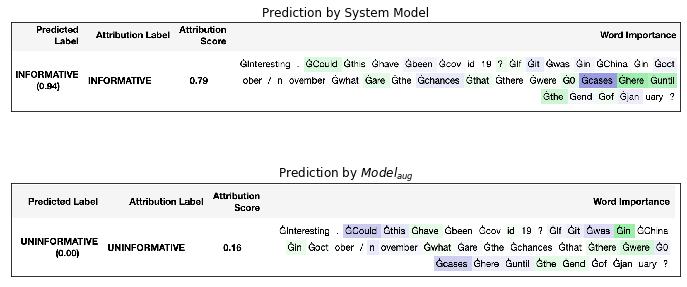

In [6]:
img1 = cv2.imread('../visualizations/model1_prediction.png')
img2 = cv2.imread('../visualizations/model3_prediction.png')

fig, ax = plt.subplots(2,1, figsize=(12,6)) #sharey=True
#gs1 = gridspec.GridSpec(2, 1)
#gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

ax[0].imshow(img1)
ax[0].set_title("Prediction by System Model")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(img2)
ax[1].set_title("Prediction by $Model_{aug}$")
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig("../visualizations/explanation1.png", dpi=200)

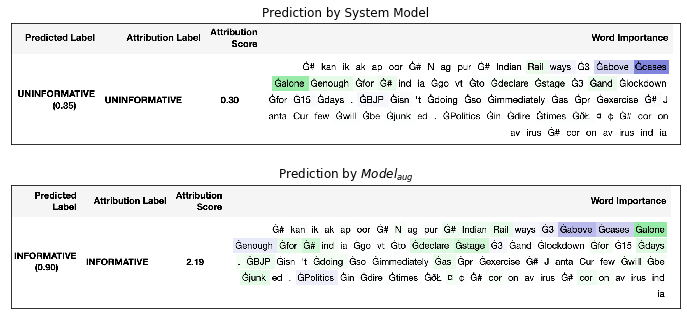

In [7]:
img1 = cv2.imread('../visualizations/model1_prediction2.png')
img2 = cv2.imread('../visualizations/model3_prediction2.png')

fig, ax = plt.subplots(2,1, figsize=(12,6)) #sharey=True
#gs1 = gridspec.GridSpec(2, 1)
#gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

ax[0].imshow(img1)
ax[0].set_title("Prediction by System Model")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(img2)
ax[1].set_title("Prediction by $Model_{aug}$")
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.subplots_adjust(wspace=0, hspace=0)
#plt.axis('off')
plt.savefig("../visualizations/explanation2.png", dpi=200)